In [8]:
# Import necessary libraries
import numpy as np
import warnings
from collections import defaultdict
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from bert_score import BERTScorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from nltk.translate.bleu_score import sentence_bleu

# Hide warnings
warnings.filterwarnings('ignore')

# Load pretrained BERT model for BERTScore
scorer = BERTScorer(model_type="bert-base-uncased", num_layers=8)

# Define true answers and generated answers for evaluation
true_answers = {
    "deadline for annual benefits enrollment": "October 20, 2021",
    "HSA contribution limit": "$3,650 for employee-only coverage or $7,300 for family coverage",
    "medical plan choices": "Consumer Directed Plan and Consumer Directed High Deductible Plan"
}

generated_answers = {
    "deadline for annual benefits enrollment": "October 20, 2021",
    "HSA contribution limit": "3650 dollars for an individual",
    "medical plan choices": "Directed Consumer Plan and High Deductible Plan"
}

# Calculate NLP-specific metrics (METEOR, ROUGE, BERTScore)
def calculate_nlp_metrics(true_answers, generated_answers):
    meteor_scores = {}
    rouge = Rouge()
    rouge_scores = {}
    bert_scores = {}
    
    for key, true_sentence in true_answers.items():
        reference = true_sentence.split()  # Tokenize the reference sentence
        hypothesis = generated_answers[key].split()  # Tokenize the hypothesis sentence
        
        # Calculate METEOR score for each key
        meteor_scores[key] = meteor_score([reference], hypothesis)
        
        # Calculate ROUGE scores
        rouge_scores[key] = rouge.get_scores(' '.join(hypothesis), ' '.join(reference), avg=True)
        
        # Calculate BERT scores
        precision, recall, f1 = scorer.score([" ".join(hypothesis)], [" ".join(reference)])
        bert_scores[key] = {
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'f1': f1.mean().item()
        }

    return meteor_scores, rouge_scores, bert_scores

# Function to calculate basic classification metrics
def calculate_basic_metrics(true_labels, predicted_labels):
    # Calculates accuracy, precision, recall, and F1 score
    return {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1 Score': f1_score(true_labels, predicted_labels)
    }

# Function to calculate F-beta scores with configurability
def calculate_fbeta_scores(true_labels, predicted_labels, beta=1.0):
    # Allows user to specify beta for the F-beta score
    return {
        f'F{beta} Score': fbeta_score(true_labels, predicted_labels, beta=beta)
    }

# Convert the true and generated answers into binary labels for classification metrics
true_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in true_answers]
generated_binary = [1 if key in ["deadline for annual benefits enrollment", "HSA contribution limit"] else 0 for key in true_answers]

# Function to calculate BLEU score for text evaluation
def calculate_text_metrics(true_answers, generated_answers):
    # Stores the BLEU scores for each question-answer pair
    bleu_scores = defaultdict(float)
    
    # Loop through each key-value pair in the true answers
    for key, true_sentence in true_answers.items():
        # Split the sentences into words for BLEU score calculation
        reference = [true_sentence.split()]
        hypothesis = generated_answers[key].split()
        # Calculate the BLEU score and store it in the dictionary
        bleu_scores[key] = sentence_bleu(reference, hypothesis)
    
    # Return the dictionary of BLEU scores
    return bleu_scores

# Calculate the basic metrics using the functions defined above
basic_metrics = calculate_basic_metrics(true_binary, generated_binary)
# Calculate the F-beta scores
fbeta_metrics = calculate_fbeta_scores(true_binary, generated_binary)
# Calculate the BLEU scores for text quality
bleu_scores = calculate_text_metrics(true_answers, generated_answers)



# Calculate all metrics
beta_value = 2  # Example: Using beta=2 to emphasize recall
binary_metrics = calculate_basic_metrics(true_binary, true_binary)  # Example where true_binary is used twice for demonstration
fbeta_metrics = calculate_fbeta_scores(true_binary, true_binary, beta=beta_value)
meteor_scores, rouge_scores, bert_scores = calculate_nlp_metrics(true_answers, generated_answers)

# Output the results of the metrics calculations
print("Binary Metrics:", binary_metrics)
print(f"F-Beta Metrics (Beta={beta_value}):", fbeta_metrics)
print("METEOR Scores:", meteor_scores)
print("ROUGE Scores:", {k: v['rouge-l']['f'] for k, v in rouge_scores.items()})
print("BERTScore:", bert_scores)
print("BLEU Scores:", bleu_scores)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Binary Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}
F-Beta Metrics (Beta=2): {'F2 Score': 1.0}
METEOR Scores: {'deadline for annual benefits enrollment': 0.9814814814814815, 'HSA contribution limit': 0.05813953488372093, 'medical plan choices': 0.7212430426716141}
ROUGE Scores: {'deadline for annual benefits enrollment': 0.999999995, 'HSA contribution limit': 0.1666666618055557, 'medical plan choices': 0.8333333283333335}
BERTScore: {'deadline for annual benefits enrollment': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'HSA contribution limit': {'precision': 0.5214697122573853, 'recall': 0.44212087988853455, 'f1': 0.4785282015800476}, 'medical plan choices': {'precision': 0.9019631147384644, 'recall': 0.8627479672431946, 'f1': 0.881919801235199}}
BLEU Scores: defaultdict(<class 'float'>, {'deadline for annual benefits enrollment': 1.2213386697554703e-77, 'HSA contribution limit': 5.474320712955125e-232, 'medical plan choices': 5.1612152302653315e-78})


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


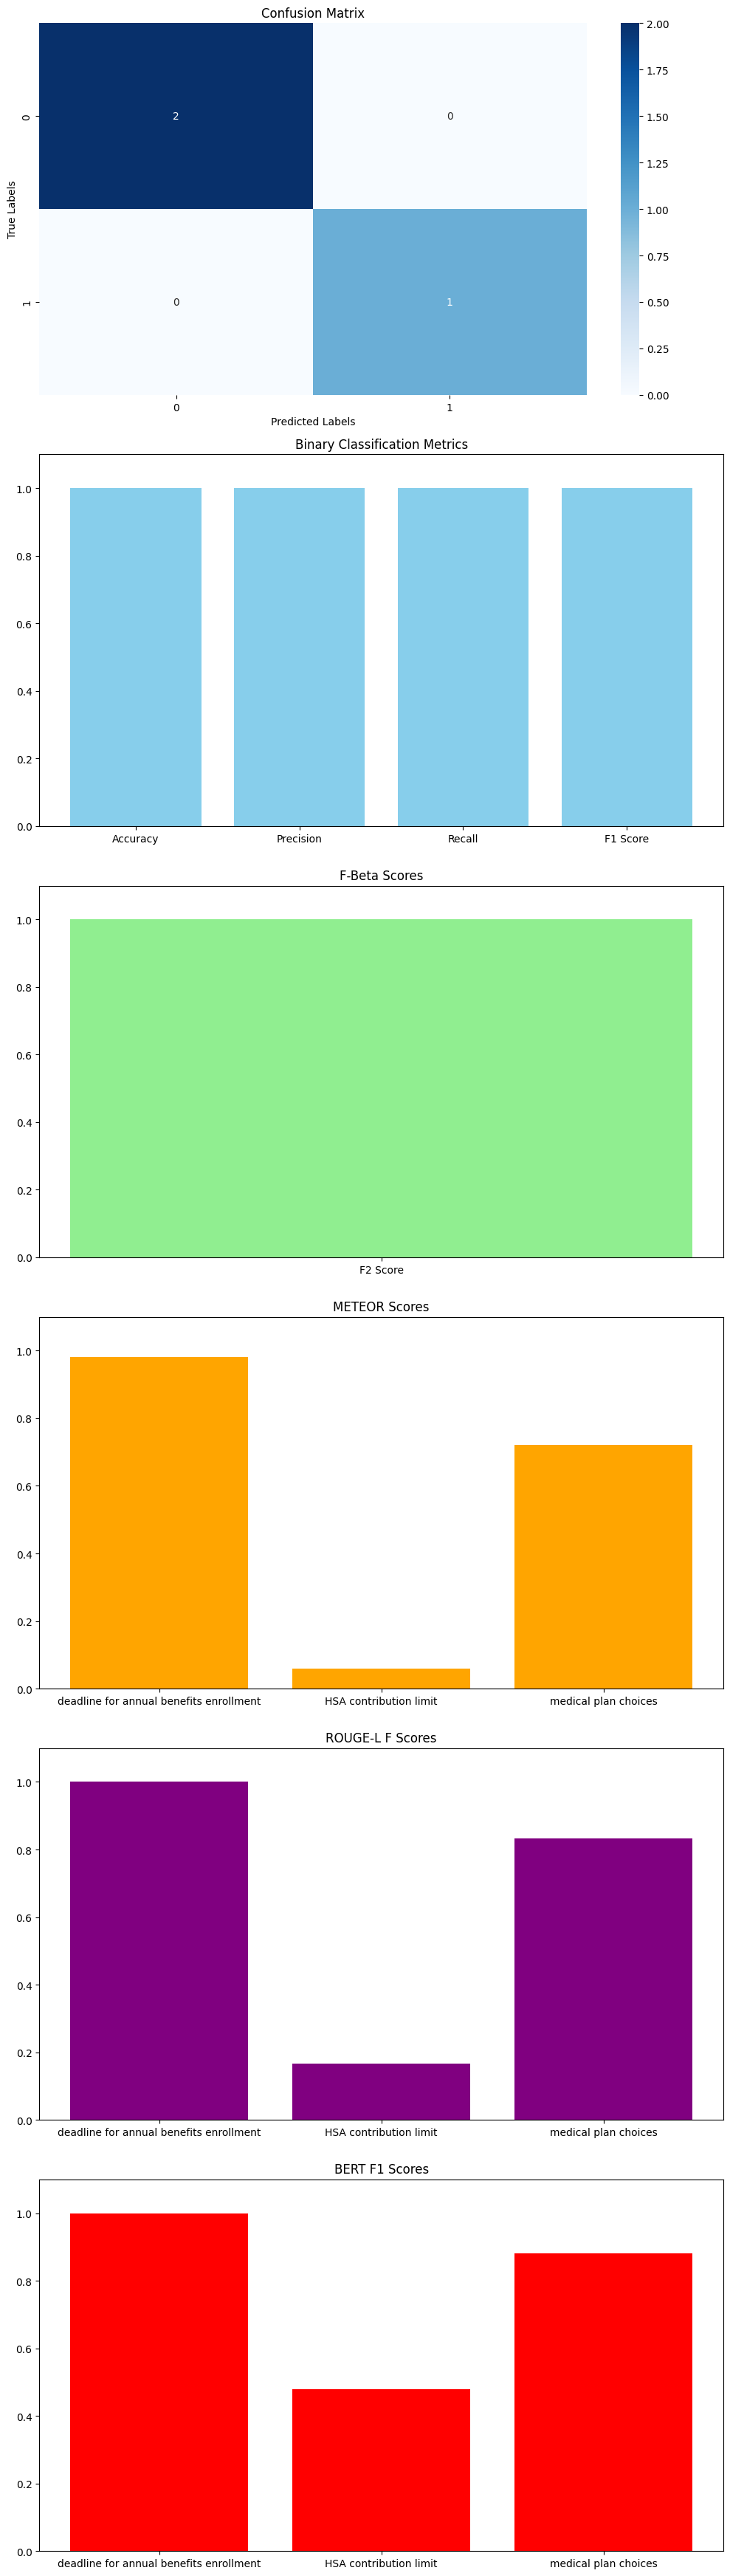

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from collections import defaultdict
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from bert_score import BERTScorer
import warnings

# Hide warnings to avoid unnecessary outputs
warnings.filterwarnings('ignore')

# Load pretrained BERT model for BERTScore calculations
scorer = BERTScorer(model_type="bert-base-uncased", num_layers=8)

# Define true answers and generated answers for evaluation
true_answers = {
    "deadline for annual benefits enrollment": "October 20, 2021",
    "HSA contribution limit": "$3,650 for employee-only coverage or $7,300 for family coverage",
    "medical plan choices": "Consumer Directed Plan and Consumer Directed High Deductible Plan"
}

generated_answers = {
    "deadline for annual benefits enrollment": "October 20, 2021",
    "HSA contribution limit": "3650 dollars for an individual",
    "medical plan choices": "Directed Consumer Plan and High Deductible Plan"
}

# Calculate NLP-specific metrics (METEOR, ROUGE, BERTScore)
def calculate_nlp_metrics(true_answers, generated_answers):
    meteor_scores = {}
    rouge = Rouge()
    rouge_scores = {}
    bert_scores = {}
    
    for key, true_sentence in true_answers.items():
        reference = true_sentence.split()
        hypothesis = generated_answers[key].split()
        
        meteor_scores[key] = meteor_score([reference], hypothesis)
        rouge_scores[key] = rouge.get_scores(' '.join(hypothesis), ' '.join(reference), avg=True)
        precision, recall, f1 = scorer.score([" ".join(hypothesis)], [" ".join(reference)])
        bert_scores[key] = {
            'precision': precision.mean().item(),
            'recall': recall.mean().item(),
            'f1': f1.mean().item()
        }

    return meteor_scores, rouge_scores, bert_scores

# Calculate basic classification metrics
def calculate_basic_metrics(true_labels, predicted_labels):
    return {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1 Score': f1_score(true_labels, predicted_labels)
    }

# Function to calculate F-beta scores with configurability
def calculate_fbeta_scores(true_labels, predicted_labels, beta=1.0):
    return {
        f'F{beta} Score': fbeta_score(true_labels, predicted_labels, beta=beta)
    }

# Convert answers into binary labels
true_binary = [1 if true_answers[key] == generated_answers[key] else 0 for key in true_answers]
predicted_binary = [1, 0, 0]  # Example generated binary outcomes for visualization

# Visualize all metrics in a comprehensive format
def visualize_all_metrics(true_binary, predicted_binary, true_answers, generated_answers):
    binary_metrics = calculate_basic_metrics(true_binary, predicted_binary)
    fbeta_metrics = calculate_fbeta_scores(true_binary, predicted_binary, beta=2)
    meteor_scores, rouge_scores, bert_scores = calculate_nlp_metrics(true_answers, generated_answers)

    fig, axs = plt.subplots(6, 1, figsize=(10, 35))  # Adjusted to 6 subplots

    # Confusion Matrix
    cm = confusion_matrix(true_binary, predicted_binary)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[0], cmap='Blues')
    axs[0].set_title('Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('True Labels')

    # Binary Metrics
    axs[1].bar(binary_metrics.keys(), binary_metrics.values(), color='skyblue')
    axs[1].set_title('Binary Classification Metrics')
    axs[1].set_ylim(0, 1.1)

    # F-beta Scores
    axs[2].bar(fbeta_metrics.keys(), fbeta_metrics.values(), color='lightgreen')
    axs[2].set_title('F-Beta Scores')
    axs[2].set_ylim(0, 1.1)

    # METEOR Scores
    axs[3].bar(meteor_scores.keys(), meteor_scores.values(), color='orange')
    axs[3].set_title('METEOR Scores')
    axs[3].set_ylim(0, 1.1)

    # ROUGE Scores
    rouge_f_scores = {key: value['rouge-l']['f'] for key, value in rouge_scores.items()}
    axs[4].bar(rouge_f_scores.keys(), rouge_f_scores.values(), color='purple')
    axs[4].set_title('ROUGE-L F Scores')
    axs[4].set_ylim(0, 1.1)

    # BERT F1 Scores
    bert_f1_scores = {key: score['f1'] for key, score in bert_scores.items()}
    axs[5].bar(bert_f1_scores.keys(), bert_f1_scores.values(), color='red')
    axs[5].set_title('BERT F1 Scores')
    axs[5].set_ylim(0, 1.1)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


# Execute the function
visualize_all_metrics(true_binary, predicted_binary, true_answers, generated_answers)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Binary Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}
F-Beta Metrics (Beta=2): {'F2 Score': 1.0}
METEOR Scores: {'deadline for annual benefits enrollment': 0.9814814814814815, 'HSA contribution limit': 0.05813953488372093, 'medical plan choices': 0.7212430426716141}
ROUGE Scores: {'deadline for annual benefits enrollment': 0.999999995, 'HSA contribution limit': 0.1666666618055557, 'medical plan choices': 0.8333333283333335}
BERTScore: {'deadline for annual benefits enrollment': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'HSA contribution limit': {'precision': 0.5214697122573853, 'recall': 0.44212087988853455, 'f1': 0.4785282015800476}, 'medical plan choices': {'precision': 0.9019631147384644, 'recall': 0.8627479672431946, 'f1': 0.881919801235199}}
